This notebook looks at exploring/visualizing the traffic data.

Data
==

First, read in the index of the data - a table of road names, descriptions, geographical locations, and paths to data.

In [62]:
import pandas as pd

# The data in index.csv is generated in the Data notebook from 
# hand-collected data in info.csv, hence the data sets are kept separate
info = pd.read_csv("road-info.csv", index_col=1)
directory = pd.read_csv("Data/Parsed/index.csv", index_col=0)

# They have the same index, though, and for the purposes of this notebook
# the columns may as well be joined into a single data frame.
info = info.join(directory)
info.head(3)

,num,TMU,location,lat,lng,path,errors
cosit,,,,,,,
NRA_000000000997,997,NRA - test site,Test site for AFMS,53.39890,-6.34177,Data/Parsed/NRA_000000000997.csv,True
NRA_000000001011,1011,TMU N01 000.0 N,M01 Airport Link Road Between R132 Swords Road...,53.42808,-6.22453,Data/Parsed/NRA_000000001011.csv,False
NRA_000000001012,1012,TMU M50 000.0 N,M50 Between Jn02 Santry and Jn03 M50\/M1,53.40305,-6.23350,Data/Parsed/NRA_000000001012.csv,False


Read the data from the filepaths marked in the index. Each road has a file of daily traffic counts

In [63]:
# Get the data from each csv into a DataFrame
data_items = {}
for cosit, record in info.iterrows():
    data_items[cosit] = pd.read_csv(record.path, index_col=0, parse_dates=[0])

# Get the common date index across all roads
any_data = next(iter(data_items.values()))
dates = any_data.index

# Combine all of the DataFrames into one
data = pd.DataFrame(index = dates)

for key, value in data_items.items():
    data[key] = value

data_original = data
data_original.head()

,NRA_000000000997,NRA_000000001011,NRA_000000001012,NRA_000000001013,NRA_000000001014,NRA_000000001015,NRA_000000001016,NRA_000000001021,NRA_000000001022,NRA_000000001023,...,NRA_000000200811,NRA_000000200812,NRA_000000201081,NRA_000000201082,NRA_000000201321,NRA_000000202103,NRA_000000202104,NRA_000000202301,NRA_000000202639,NRA_000000208001
2020-01-01,48037.0,42040,46676,30271,82415,30716,19562,5884,5955,7529,...,21102,14524,15624,8860,12580,6382,6994,4024.0,3343,6439
2020-01-02,48029.0,55529,73797,38977,119203,49083,31498,9586,9349,14742,...,36154,22919,31373,17169,17771,8204,9209,4921.0,5782,13035
2020-01-03,48053.0,58686,79358,41581,129412,55222,34990,10358,10143,15933,...,40565,24713,33121,17757,19528,7846,9008,5027.0,6494,14752
2020-01-04,48079.0,52346,64556,36858,108989,45257,27624,8259,7555,11696,...,32331,19595,27204,12708,16733,6782,7822,4274.0,5364,12781
2020-01-05,48091.0,58328,60109,36896,107231,43289,25651,7435,7451,9731,...,26378,18014,24030,12581,15207,6170,6947,3791.0,4254,9700


Graphs
==

Quick tangent: try to define a slightly calmer colour cycle for matplotlib lines.

In [163]:
from cycler import cycler
import matplotlib.pyplot as plt
import numpy as np

cmap = plt.get_cmap("Set1")
colors = list(map(cmap, np.linspace(0, 0.5, 5)))

cycle = cycler(color=colors)
plt.rc("axes", prop_cycle=cycle)

Basic direct plot of all values. This is a mess of noise, no surprises there.

Text(0, 0.5, 'Counts')

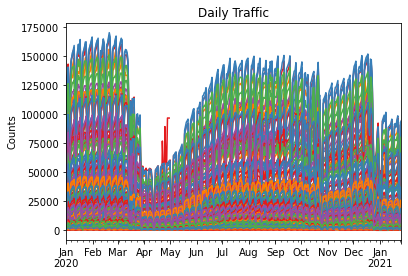

In [167]:
data_original.plot(legend=False)
plt.title("Daily Traffic")
plt.ylabel("Counts")

The trend is somewhat sensible, at least - a big dropoff with the initial lockdown, and then traffic mostly resumes later in the year.

The jaggedness in the plot is the weekly cycle - busy weekdays, quiet weekends. A rolling average can smooth that out, that is done below.

Text(0, 0.5, 'Counts')

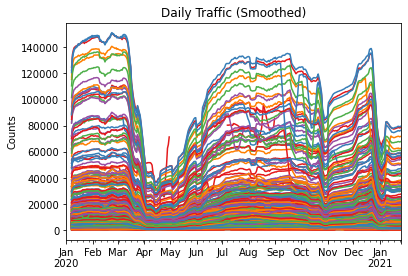

In [168]:
import matplotlib.pyplot as plt

smoothed_data = data_original.rolling(window=7).mean()

smoothed_data.plot(legend=False)
plt.title("Daily Traffic (Smoothed)")
plt.ylabel("Counts")

That smooths out the jaggedness, and makes the general shape much clearer. However, most of the lines look very similar considering they are supposed to be from different roads.

Perhaps this is because all the highest counts come from one place. (Dublin city center, perhaps?)

If that is the case, the normalized counts should vary much more.

Text(0, 0.5, 'Count Proportion')

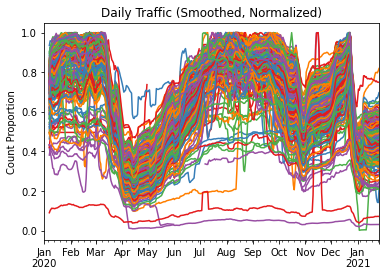

In [169]:
import matplotlib.pyplot as plt

normalized_data = smoothed_data / smoothed_data.max()

normalized_data.plot(legend = False)
plt.title("Daily Traffic (Smoothed, Normalized)")
plt.ylabel("Count Proportion")

That's much more variance. One interesting thing that can be done is to make the lines mostly transparent, so that as they layer up the create a line that represents where most of them are.

Text(0, 0.5, 'Count Proportion')

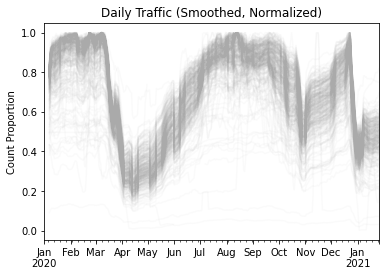

In [170]:
ax = plt.gca()

normalized_data.plot(ax = ax, legend = False, color="#aaa", alpha=0.05)
#normalized_data.mean(axis=1).plot(ax = ax, style="r", linewidth=5)

plt.title("Daily Traffic (Smoothed, Normalized)")
plt.ylabel("Count Proportion")

We can compare this to the pointwise mean. 

It's worth nothing that the roads aren't evenly distributed around Ireland, again, Dublin is represented more than other counties (and the east coast in general has a lot of data points). So the trend might not be representative of the entire country.

Text(0, 0.5, 'Count Proportion')

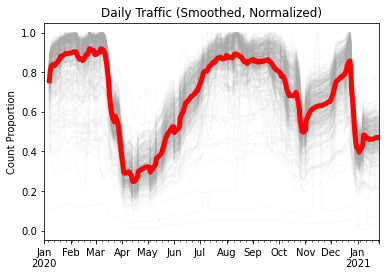

In [171]:
ax = plt.gca()

normalized_data.plot(ax = ax, legend = False, color="#aaa", alpha=0.05)
normalized_data.mean(axis=1).plot(ax = ax, style="r", linewidth=5)

plt.title("Daily Traffic (Smoothed, Normalized)")
plt.ylabel("Count Proportion")

Maps
==

Onto maps! In order to plot Ireland to any accuracy, it seems we need a shapefile. I found a neat little one here: https://gist.github.com/martinbpeters/34e258dadca967393291b7a128857350

<AxesSubplot:>

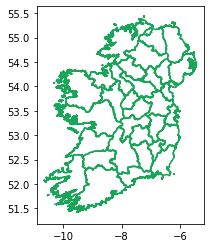

In [8]:
import geopandas as gpd

counties = gpd.read_file("Data/counties.geojson")
counties = counties.set_crs(epsg=4326)
counties.boundary.plot(color = "#18A558")

The irish border without counties will also be useful. This shape can be recovered as the union of the county shapes.

<AxesSubplot:>

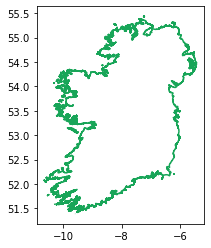

In [9]:
ireland = gpd.GeoSeries(counties.unary_union).set_crs(epsg=4326)
ireland.boundary.plot(color = "#18A558")

Road locations, then

<AxesSubplot:>

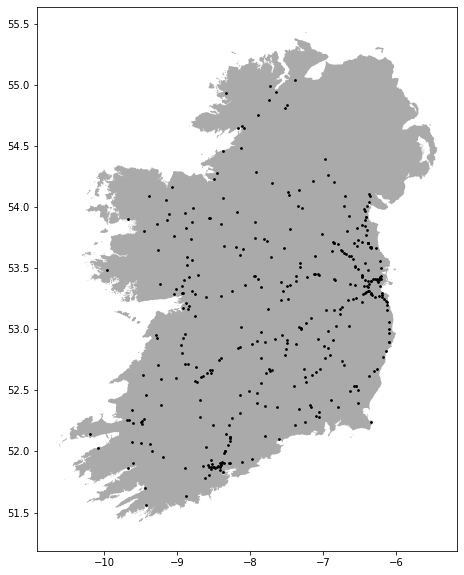

In [10]:
import geopandas as gpd
from shapely.geometry import Point

# For aesthetics, I'll use the "plasma" matplotlib colour scheme as base
background = "#140F79"
foreground = "#FCA537"
border = "#aaa"

geoinfo = gpd.GeoDataFrame(info)

geometry = list()
for i, record in info.iterrows():
    geometry.append(Point(record.lng, record.lat))
    
geoinfo["geometry"] = geometry

geoinfo = geoinfo.set_crs(epsg=4326)

ax = ireland.plot(figsize=(10,10), color="#aaa")
geoinfo.plot(ax = ax, color="black", markersize=3)

We can compare this to a tiling as an extra consistency check. This can take a while to run the first time.

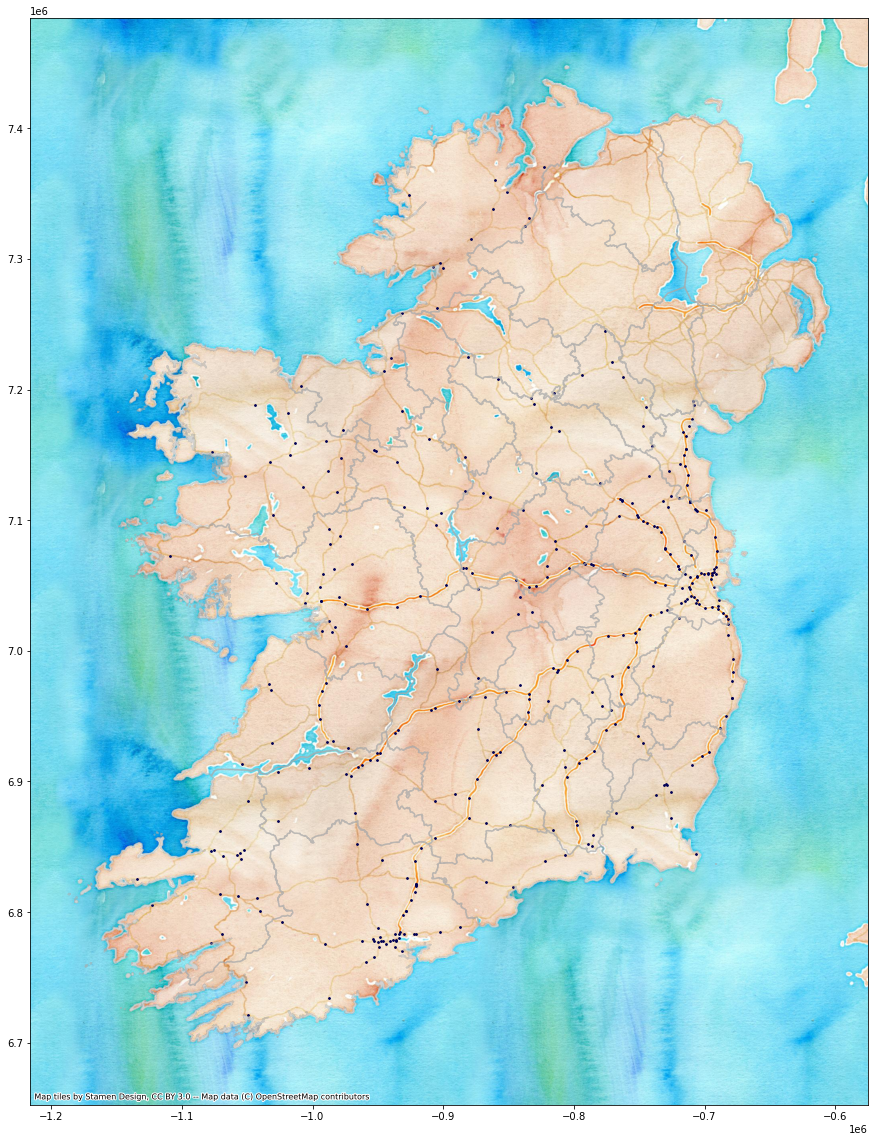

In [11]:
import contextily as ctx

ax = geoinfo.to_crs(epsg=3857).plot(figsize=(20,20), color="#005", markersize=3)
counties.to_crs(epsg=3857).boundary.plot(ax=ax, color="#aaa", alpha=0.5)
ctx.add_basemap(ax, zoom=9, source=ctx.providers.Stamen.Watercolor)

The concentration of data points in the east is very visible here, some of the graphs above would be better revisited after the data is regrouped by county.

Taking a look at the max counts here, with the previous observation that the curves with the largest magnitude were almost identical in mind.

<AxesSubplot:>

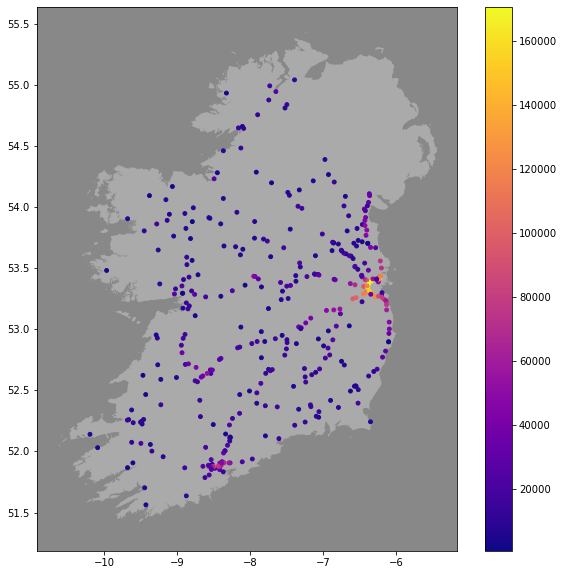

In [12]:
geoinfo_max = geoinfo.copy()
geoinfo_max["max"] = data_original[geoinfo.index].max()

ax = ireland.plot(figsize=(10,10), color=border)
ax.set_facecolor("#888")
geoinfo_max.plot(ax = ax, column="max", legend=True, cmap="plasma", markersize=15)

(52.9, 53.9)

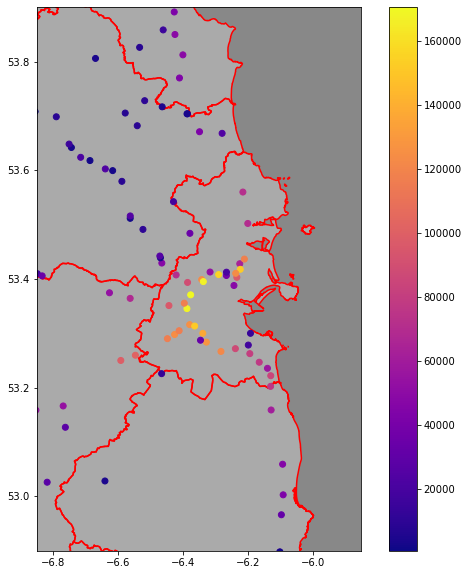

In [13]:
geoinfo_max = geoinfo.copy()
geoinfo_max["max"] = data_original[geoinfo.index].max()

ax = ireland.plot(figsize=(10,10), color="#aaa")
ax.set_facecolor("#888")
counties.boundary.plot(ax = ax, color="red")
geoinfo_max.plot(ax = ax, column="max", legend=True, cmap="plasma", zorder=2)

ax.set_xlim(-6.85, -5.85)
ax.set_ylim(52.9, 53.9)

Highest counts are indeed concentrated around Dublin. No surprises there.

The normalized means, plotted below, are pretty consistent, though that doesn't mean much. What is telling is that they are so high, most are roughly 0.7-0.8. Lockdown didn't reduce overall traffic in the year by as much as I expected.

<AxesSubplot:>

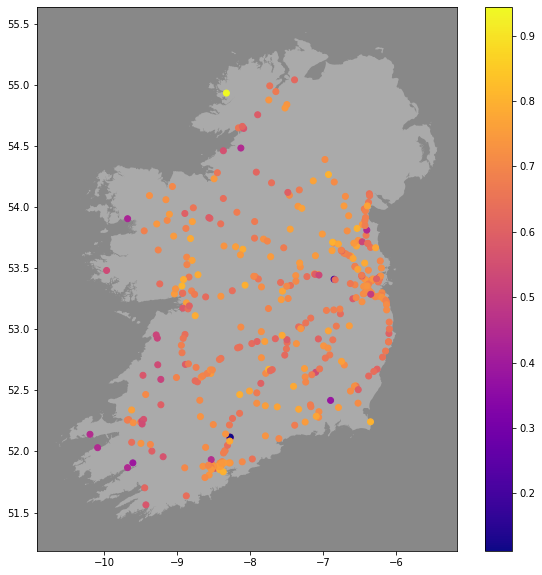

In [14]:
geoinfo_max = geoinfo.copy()
geoinfo_max["value"] = normalized_data[geoinfo.index].mean()

ax = ireland.plot(figsize=(10,10), color="#aaa")
ax.set_facecolor("#888")
geoinfo_max.plot(ax = ax, column="value", legend=True, cmap="plasma")

Animation
==


This is done in two steps, here - a series of PNG images are prepared using matplot lib and stored in a list, and then they are played back using IPython. This is because the actual plotting takes much too long to be usable in real-time. (There might be ways to shorten it, but this will do for now.)

Below is the function for preparing the animation.

In [179]:
from IPython.display import DisplayHandle, Markdown
import io


# I'm not sure how this can be sped up.

# Cloning the axis so that the map doesn't have to be
# redrawn works, if pickling is used to do the clone. This
# speeds it up a little, but not enough to be worth the complication.

# Reusing the axes without cloning, and deleting data previously
# plotted, seems to slow it down drastically for some reason. This
# really confused me, I don't know why it would happen.
# (The key line here was ax.get_children().pop(1).remove())

# It's probably possible to create separate pngs for
# the background and data and blend them, but that's for
# another day.


def prepare_animation(data, vmin = 0, vmax = 1):

    frames = list()
    geoinfo_frame = geoinfo.copy()

    dates = data.index[6:]

    handle = DisplayHandle()
    handle.display(Markdown(f"Progress: 0/{len(dates)}"))
    
    for i, date in enumerate(dates):

        geoinfo_frame["value"] = data.loc[date]

        ax = ireland.plot(figsize=(10,10), color="#aaa")
        ax.set_facecolor("#888")
        
        result = geoinfo_frame.plot(ax = ax, column="value", legend=True, cmap="plasma", vmin=vmin, vmax=vmax)
        plt.title(date)

        frame_stream = io.BytesIO()
        plt.savefig(frame_stream)
        
        plt.close()
        
        frame_stream.seek(0)
        frames.append(frame_stream.read())

        handle.update(Markdown(f"Progress: {i+1}/{len(dates)}"))
        
    return frames

And then the function for actually playing the animation. 

It would be nice to keep to IPython without needing the widgets dependency, but manually changing the IPython Image seems to be much to slow for long animations. 
<br>(It does work for short ones, perhaps because there is a browser cache somewhere getting involved? But the animations here exceed the limit.)

In [180]:
from ipywidgets import Image
import time


def play_animation(frames):
    
    image = Image(value = frames[0], height=500, width = 500)
    display(image)

    for frame in frames[1:]:
        image.value = frame
        time.sleep(0.032)

An animation of normalized traffic counts. These take a while to prepare!

In [181]:
frames_normalized = prepare_animation(normalized_data)

Progress: 386/386

In [ ]:
play_animation(frames_normalized)

I have to admit, while there is variance, the country is much more in sync than I expected.

The last thing for now will be an attempt to highlight where what variance there might be is. Subtracting the daily mean will do this.

Quick reminder, the normalized data looks like this:

<AxesSubplot:>

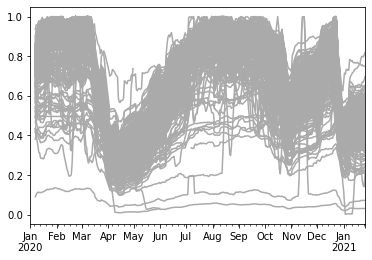

In [39]:
normalized_data.plot(legend=False, color="#aaa")

Subtracting means:

<AxesSubplot:>

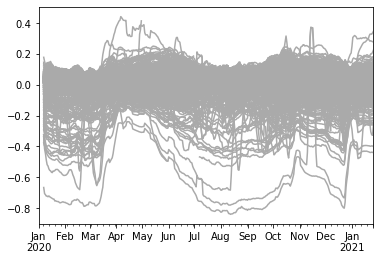

In [40]:
# Getting the axes right here is tricky
daily_means = normalized_data.mean(axis=1)
mean_subtracted_data = normalized_data.sub(daily_means, axis=0)

mean_subtracted_data.plot(legend=False, color="#aaa")

From the above, a vmin,vmax of -0.4, 0.2 seems reasonable. (Ignoring outliers. The above graph might be better with the interquartile mean, actually.)

In [182]:
frames_mean_subtracted = prepare_animation(mean_subtracted_data, vmin = -0.4, vmax=0.2)

Progress: 386/386

In [51]:
play_animation(frames_mean_subtracted)

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x02\xd0\x00\x00\x02\xd0\x08\x06\x00\x00\x00\xb9WG\x9…

Again, with vmin being -0.2 instead of -0.4:

In [184]:
frames_mean_subtracted_2 = prepare_animation(mean_subtracted_data, vmin = -0.4, vmax=0.2)

Progress: 386/386

In [55]:
play_animation(frames_mean_subtracted_2)

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x02\xd0\x00\x00\x02\xd0\x08\x06\x00\x00\x00\xb9WG\x9…

Conclusion is the same as before, there is less variance than I expected. It seems quite possible that most information contained in this dataset is also contained in the pointwise mean from before:

Text(0, 0.5, 'Count Proportion')

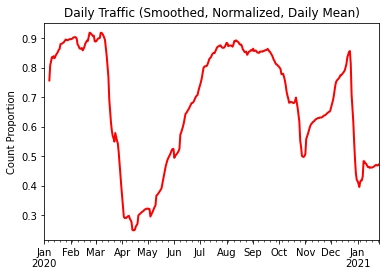

In [178]:
ax = plt.gca()

#normalized_data.plot(ax = ax, legend = False, color="#aaa", alpha=0.01)
normalized_data.mean(axis=1).plot(ax = ax, style="r", linewidth=2)

plt.title("Daily Traffic (Smoothed, Normalized, Daily Mean)")
plt.ylabel("Count Proportion")

One idea that occured to me was to label the data according to whether it was along the UK border, or in a city, or rural, or intercounty. There could be some interesting differences there. It would be quite a bit of manual work though, so leaving it for another day.